# 前言
- 数据集链接：https://tianchi.aliyun.com/competition/entrance/231715/information
- 以下主要分成三个部分：
  - Part one:数据集简明介绍
  - Part two:数据预处理
  - Part three:数据可视化分析

# Part one：数据集介绍
## 1.1 活动背景
- 共享，通过让渡闲置资源的使用权，在有限增加边际成本的前提下，提高了资源利用效率。随着信息的透明化，越来越多的共享发生在陌生人之间。短租，共享空间的一种模式，不论是否体验过入住陌生人的家中，你都可以从短租的数据里挖掘有趣的信息。
- 活动采用了短租房源相关的公开数据，包括了结构化的表格数据、非结构化的文本和地图数据。可在统计分析、时间序列、关系网络分析、中英文自然语言处理、数据可视化以及数据应用等多角度都可以进行探索。

## 1.2 数据说明
- 数据分为汇总版和明细版两类。
- listings 数据为短租房源基础信息，包括房源、房东、位置、类型、价格、评论数量和可租时间等等。明细版listings_detail 中包含更多房源相关细节。
- calendar 数据为短租房源时间表信息，包括房源、时间、是否可租、租金和可租天数等等。
- reviews 数据为短租房源的评论信息。汇总版中仅包括房源 listing_id和评论日期，用来时间序列和数据可视化分析。明细版reviews_detail 还包括评论相关的内容和作者信息。
- neighbourhoods 数据为北京的行政区划。
- 数据来源：本次活动数据来自 Airbnb 于 2019 年 4 月 17 日公开的北京地区数据。数据均来源于 Airbnb 网站的公开信息，不包含任何个人隐私数据。感谢相关机构做出的数据工作，更多信息可访问 http://insideairbnb.com/get-the-data.html。

## 1.3 分析所用数据集介绍
- 本次分析主要使用listings_detail 数据集，其中包含106个特征，28452条数据。
- 数据集主要包含了短租房源的基础信息，如房源、房东、地理位置、价格、评论数量等等。通过对特征进行初步筛选，丢掉部分无用信息，最终提取46个特征，主要分为一下几类：房东特征（服务、可信度、房东类型等）、房源特征（起始时间、地理位置、硬件设施、价格等等）、房客特征（住房反馈等）。

# Part two：数据预处理

## 2.1 数据准备

In [28]:
# 导入必要库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
import pandas_profiling
import missingno as msno
import datetime
import re
import os

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
# 提取主要特征
detail = pd.read_csv('listings_detail.csv')
data_save = detail.iloc[:,[0,19,22,25,26,28,32,34,35,36,39,48,49,50,51,52,53,
                       54,55,56,57,58,60,63,64,65,66,67,68,75,80,82,83,84,
                       85,86,87,88,89,90,91,92,96,98,105]]

# 根据Calendar_details，计算未来一段时间内各房源的预订率
calendar = pd.read_csv('calendar_detail.csv')
calendar_f =  pd.DataFrame(calendar.loc[(calendar['available'] == 'f')].groupby(by=['listing_id'])['date'].count())
calendar_t = pd.DataFrame(calendar.loc[(calendar['available'] == 't')].groupby(by=['listing_id'])['date'].count())
calendar_count = pd.DataFrame(calendar.groupby(by = ['listing_id'])['date'].count())
rating = calendar_f / calendar_count

data1 = pd.merge(data_save, rating, how = 'left', left_on = 'id', right_index = True)
data1.rename(columns = {'date':'rating'}, inplace = True)

data1.to_csv('data1.csv',index = False)

print("variables：", data1.columns.values)

variables： ['id' 'host_id' 'host_since' 'host_response_time' 'host_response_rate'
 'host_is_superhost' 'host_listings_count' 'host_verifications'
 'host_has_profile_pic' 'host_identity_verified' 'neighbourhood_cleansed'
 'latitude' 'longitude' 'is_location_exact' 'property_type' 'room_type'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities'
 'price' 'security_deposit' 'cleaning_fee' 'guests_included'
 'extra_people' 'minimum_nights' 'maximum_nights' 'calendar_updated'
 'availability_365' 'number_of_reviews' 'number_of_reviews_ltm'
 'first_review' 'last_review' 'review_scores_rating'
 'review_scores_accuracy' 'review_scores_cleanliness'
 'review_scores_checkin' 'review_scores_communication'
 'review_scores_location' 'review_scores_value' 'instant_bookable'
 'cancellation_policy' 'reviews_per_month' 'rating']


In [19]:
data1.to_csv('data1.csv',index = False)

## 2.2 数据预处理

### 2.2.1 缺失情况展示

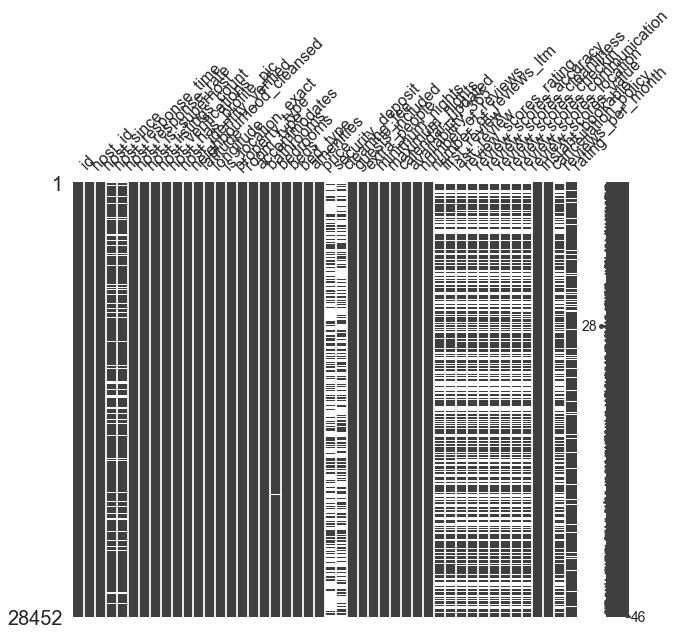

In [20]:
#数据缺失情况展示
plt = msno.matrix(data1.sample(data1.shape[0]), figsize = (10, 8), width_ratios = (15, 1))

- 白色部分代表缺失值
- 数据缺失情况较为严重的是与住客反馈相关的“review”类特征，以及“security_deposit”和“cleaning_fee”两个特征。

### 2.2.2 数据处理

In [25]:
# 1. 变量：'security_deposit'&'cleaning_fee'填补缺失值，货币符号转换

data1 = pd.read_csv("data1.csv")
data1.loc[:5, ['security_deposit', 'cleaning_fee']]

## 缺失值补零

data1['security_deposit'] = data1['security_deposit'].fillna(0)
data1['cleaning_fee'] = data1['cleaning_fee'].fillna(0)

##货币符号转换

for index, row in data1.iterrows():
    a = getattr(row, 'security_deposit')
    b = getattr(row, 'cleaning_fee')
    if type(a) == str:
        a = float(re.sub('[$,]', '', a))
        data1.loc[index, 'security_deposit'] = a
    if type(b) == str:
        b = float(re.sub('[$,]', '', b))
        data1.loc[index, 'cleaning_fee'] = b

data1.loc[:5, ['security_deposit', 'cleaning_fee']]

,security_deposit,cleaning_fee
0,$671.00,$67.00
1,$0.00,$0.00
2,$0.00,$0.00
3,NaN,NaN
4,NaN,NaN
5,$700.00,$0.00


,security_deposit,cleaning_fee
0,671,67
1,0,0
2,0,0
3,0,0
4,0,0
5,700,0


In [26]:
data1.to_csv('data1.csv', index = False)

In [27]:
# 2. 变量'neighbourhood_cleansed'的字符转换

data2 = data1.copy()
data2.loc[:5, 'neighbourhood_cleansed']
rep = {'朝阳区 / Chaoyang':'Chaoyang', '东城区':'Dongcheng', '海淀区':'Haidian',   
       '丰台区 / Fengtai':'Fengtai', '西城区':'Xicheng', '通州区 / Tongzhou':'Tongzhou',
       '昌平区':'Changping', '密云县 / Miyun':'Miyun', '顺义区 / Shunyi':'Shunyi',
       '怀柔区 / Huairou':'Huairou', '大兴区 / Daxing':'Daxing', '延庆县 / Yanqing':'Yanqing',
       '房山区':'Fangshan', '石景山区':'Shijing', '门头沟区 / Mentougou':'Mentougou', '平谷区 / Pinggu':'Pinggu'}

rep = dict((re.escape(k), v) for k, v in rep.items())
pattern = re.compile("|".join(rep.keys()))

for index, row in data2.iterrows():
    a = getattr(row, 'neighbourhood_cleansed')
    my_str = pattern.sub(lambda m: rep[re.escape(m.group(0))], a)
    data2.loc[index, 'neighbourhood_cleansed'] = my_str
    
data2.loc[:5, 'neighbourhood_cleansed']

data2.to_csv('data2.csv', index = False)

0    朝阳区 / Chaoyang
1       密云县 / Miyun
2               东城区
3               东城区
4    朝阳区 / Chaoyang
5               东城区
Name: neighbourhood_cleansed, dtype: object

0     Chaoyang
1        Miyun
2    Dongcheng
3    Dongcheng
4     Chaoyang
5    Dongcheng
Name: neighbourhood_cleansed, dtype: object

In [29]:
# 3. 变量'host_since'转化成到数据收集日（2019 年 4 月 17 日）的天数

data3 = data2.copy()
data3.iloc[:5, 2]

now = '2019-04-17'
data3.iloc[:, 2] = data3.iloc[:, 2].apply(lambda x: int((datetime.datetime.strptime(now, '%Y-%m-%d') 
                                                         - datetime.datetime.strptime(x, '%Y-%m-%d')).days))

data3.iloc[:5, 2]

0    2010-08-06
1    2011-04-22
2    2011-03-28
3    2011-06-16
4    2011-06-16
Name: host_since, dtype: object

0    3176
1    2917
2    2942
3    2862
4    2862
Name: host_since, dtype: int64

In [30]:
# 4. 变量'host_response_time'&'host_response_rate'的缺失处理
# 'host_response_time'缺失则划分为新类“no body cares”
# 'host_response_rate'字符百分数转换成浮点数
# 'host_response_rate'缺失则取平均

data4 = data3.copy()
data4.loc[:5, ['host_response_time', 'host_response_rate']]

#'host_response_time'处理
data4.iloc[:, 3] = data4['host_response_time'].replace(np.nan, 'no body cares')

# 'host_response_rate'处理
data4.iloc[:, 4] = data4.iloc[:, 4].apply(lambda x: float(x.strip('%')) if type(x) == str else x)
data4.iloc[:, 4] = data4.iloc[:, 4].fillna(data4['host_response_rate'].mean())
data4.iloc[:, 4] = data4.iloc[:, 4].apply(lambda x: "%.3f"% (x / 100))

data4.loc[:5, ['host_response_time', 'host_response_rate']]
data4.to_csv('data4.csv', index = False)

,host_response_time,host_response_rate
0,within an hour,100%
1,NaN,NaN
2,within a few hours,100%
3,within an hour,100%
4,within an hour,100%
5,within an hour,71%


,host_response_time,host_response_rate
0,within an hour,1.000
1,no body cares,0.941
2,within a few hours,1.000
3,within an hour,1.000
4,within an hour,1.000
5,within an hour,0.710


In [31]:
# 5. 变量'bathrooms'&'bedrooms'&'beds'的缺失均补0
data5 = data4.copy()
data5['bathrooms'] = data5['bathrooms'].fillna(0)
data5['bedrooms'] = data5['bedrooms'].fillna(0)
data5['beds'] = data5['bedrooms'].fillna(0)

0    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1    {Internet,Wifi,"Air conditioning","Free parkin...
2    {TV,Internet,Wifi,"Air conditioning",Doorman,B...
3    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
4    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
5    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
Name: amenities, dtype: object

0    33
1    21
2    10
3    21
4    16
5    17
Name: amenities, dtype: int64

64

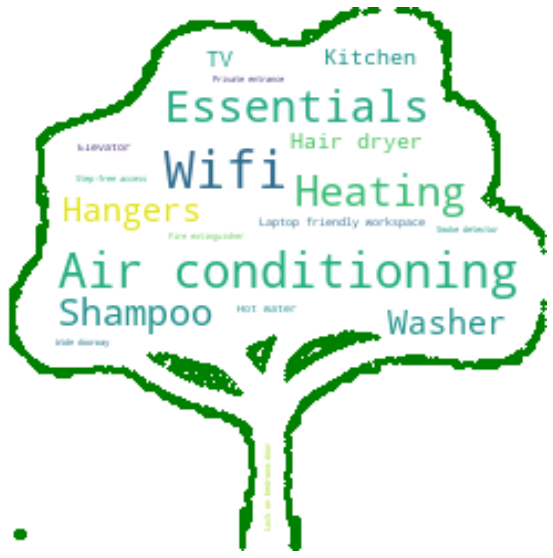

In [35]:
# 6. 变量'amenities'统计元素个数并绘制词云图

data6 = data5.copy()
data6.loc[:5, 'amenities']

data6['amenities'] = data6['amenities'].apply(lambda x: x.count(',') + 1)

data6.loc[:5, 'amenities']
data6.to_csv('data6.csv', index = False)

## 绘制词云图
a = data5['amenities'].apply(lambda x: pd.DataFrame(x.split(',')))
count = {}
for i in a:
    d = pd.DataFrame(i)
    word = d[0].apply(lambda x: re.sub('[{"}"]', '', x))
    for j in word:
        if j in count.keys():
            count[j] = count[j] + 1
        else:
            count[j] = 1

count.pop('')  #删除空关键字
count['toilet'] = count.pop(' toilet')

def wc_from_word_count(word_count, fp):
    bg = np.array(Image.open("./pictures/tree.jpg"))
    wc = WordCloud(
        max_words = 100,  # 最多显示词数
        background_color = "white",  # 设置背景为白色，默认为黑色
        width = 3000,  # 设置图片的宽度
        height = 2000,  # 设置图片的高度
        margin = 10,  # 设置图片的边缘
        mask = bg,
        contour_width = 3,
        contour_color='green'
    )
    image_colors = ImageColorGenerator(bg)
    wc.generate_from_frequencies(word_count) # 从字典生成词云
    ax = fig.add_subplot(1,1,1)
    ax.imshow(wc, interpolation='bilinear')  # 显示词云
    ax.axis('off')  # 关闭坐标轴
    wc.to_file(fp)  # 保存图片
    
#调用词云函数
fig = plt.figure(figsize = (10, 10))
wc_from_word_count(count, './pictures/1.jpg')

In [36]:
# 7. 变量'price'&'extra people'货币符号转换
data7 = data6.copy()
data7.loc[:5, ['price', 'extra_people']]

data7['price'] = data7['price'].apply(lambda x: re.sub('[$,]', '', x))
data7['extra_people'] = data7['extra_people'].apply(lambda x: re.sub('[$,]', '', x))

data7.loc[:5, ['price', 'extra_people']]
data7.to_csv('data7.csv', index = False)

,price,extra_people
0,$792.00,$67.00
1,"$1,201.00",$0.00
2,$389.00,$101.00
3,$376.00,$0.00
4,$537.00,$0.00
5,$403.00,$64.00


,price,extra_people
0,792.00,67.00
1,1201.00,0.00
2,389.00,101.00
3,376.00,0.00
4,537.00,0.00
5,403.00,64.00


In [37]:
# 8. 用calendar_detail计算入住率，并将入住率合并到数据集中
calendar = pd.read_csv('calendar_detail.csv')
occup = calendar.available.loc[(calendar['available'] == 'f')].count()   #available字段为非可用，表示这天得房子已经出租出去。
alldays = calendar.available.count() #总数
occuprate = round(occup / alldays * 100, 2)  #使用数比总数，求出总得使用率
print('总使用率为:{0}%，总数为:{1},使用总天数为:{2}'.format(occuprate, alldays, occup))

calendar_f =  pd.DataFrame(calendar.loc[(calendar['available'] == 'f')].groupby(by = ['listing_id'])['date'].count())
calendar_t = pd.DataFrame(calendar.loc[(calendar['available'] == 't')].groupby(by = ['listing_id'])['date'].count())
calendar_count = pd.DataFrame(calendar.groupby(by = ['listing_id'])['date'].count())

rating = round(calendar_f / calendar_count, 3)
rating['date'] = rating['date'].fillna(0)

data8 = pd.merge(data7, rating, how = 'left', left_on = 'id', right_index = True)
data8.rename(columns = {'date':'rating'}, inplace = True)

data8.to_csv('data8.csv', index = False)

总使用率为:39.21%，总数为:10384980,使用总天数为:4071548


In [38]:
# 9. 对最后几个变量进行缺失值处理
# 删除变量'first_review'和'last_review'
# 评分按级别划分：若未缺失，则满分为1，非满分为-1，缺失为0

data9 = data8.copy()
data9.drop(['first_review','last_review'], 1 , inplace = True)

# review_scores_rating
data9['review_scores_rating'] = data9['review_scores_rating'].apply(lambda x:-1 if x <100 else x)
data9['review_scores_rating'] = data9['review_scores_rating'].apply(lambda x:1 if x == 100 else x)
data9['review_scores_rating'] = data9['review_scores_rating'].fillna(0)

score = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
         'review_scores_communication', 'review_scores_location', 'review_scores_value']

for i in score:
    data9[i] = data9[i].apply(lambda x:-1 if x < 10 else x)
    data9[i] = data9[i].apply(lambda x:1 if x == 10 else x)
    data9[i] = data9[i].fillna(0)

data9['reviews_per_month'] = data9['reviews_per_month'].fillna(0)
data9.to_csv('data9.csv', index = False)

# Part three：数据可视化

## 3.1 重要特征分布

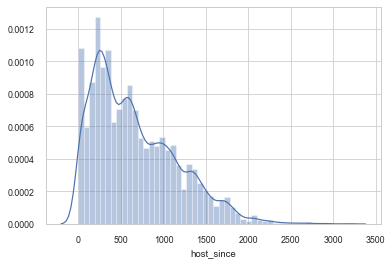

In [42]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

# host_since（房东注册时长）

sns.set(context = 'paper', style = "whitegrid")
data9 = pd.read_csv('data9.csv')
sns.distplot(data9.host_since)

- 目前北京的短租房源多数是近三年注册的，符合17年Airbnb大举进入中国的发展背景。近几年来，中国的短租市场蒸蒸日上，在消费升级的背景下，共享民宿，短租住宿成为新的消费增长点。

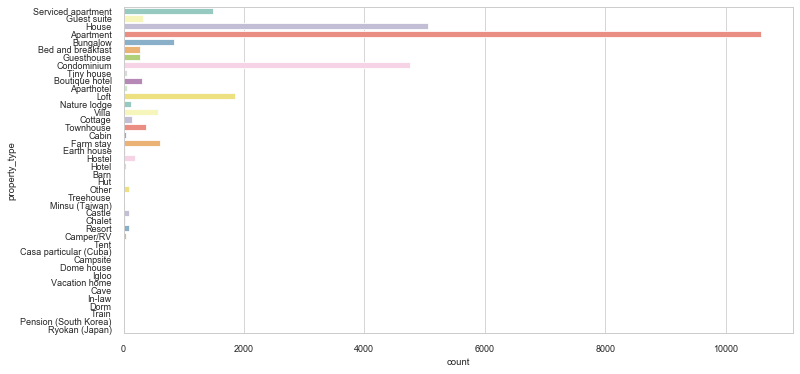

In [43]:
# property_type（房源类型）

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1,1,1)
ax = sns.countplot(y='property_type', palette = "Set3", data = data9)
ax.tick_params(labelsize = 9)

- 北京短租房源市场中，Apartment（公寓型房源）“一枝独秀”，而House（家庭式住宅）和Condominium（分契式公寓）类型的房源在整个市场中也占据较大比重。

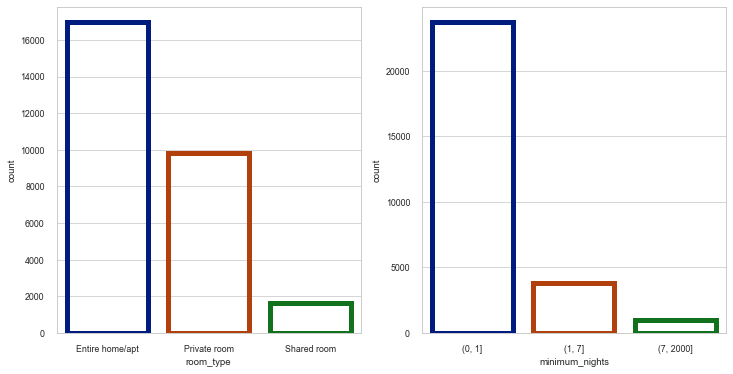

In [44]:
# room_type（房间类型）

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.countplot(x = 'room_type', data = data9, facecolor=(0, 0, 0, 0),
                    linewidth = 5, edgecolor = sns.color_palette("dark", 3))

# minimum_nights（最少入住天数）
data9['minimum_nights'].unique()
bins = [0,1,7,2000]
df = pd.cut(data9['minimum_nights'], bins)
ax2 = fig.add_subplot(1,2,2)
ax2 = sns.countplot(x = df, facecolor=(0, 0, 0, 0), linewidth = 5,
                    edgecolor = sns.color_palette("dark", 3))

- 目前，北京短租房市场中，主要存在以下三种房间出租类型：整套出租，整间出租以及共享房间。其中，整套出租占比最高，整间出租次之，共享房间的形式也占据一定比重。
- 在Airbnb平台上，房主可对房客设置最低入住时长。从上图来看，绝大多数房源入住时间为1天起步，只有少数房东较为“苛刻”，或者是由于房源类型的特殊性，要求房客最低入住七天以上。

<Figure size 1080x504 with 0 Axes>

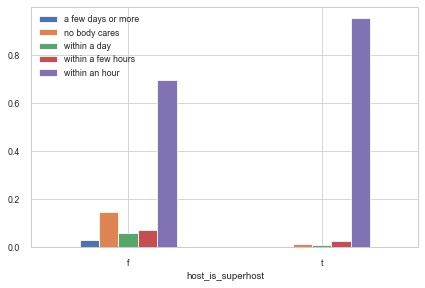

In [45]:
# 房东回复时长在superhost与commonhost内的频率
tab1 = pd.crosstab(data9['host_is_superhost'], data9['host_response_time'])
tab1_std = tab1.div(tab1.sum(1), axis = 0)

plt.figure(figsize = (15,7))
tab1_std.plot.bar()
plt.tight_layout()
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')
plt.show()

- Airbnb平台于2009年启动了Superhost（明星房东）计划，旨在表彰早期为Airbnb社区的出租行为树立了高标准的优秀房东。而成为明星房东需要满足以下条件：对房客的回复率至少达到90%；没有取消预订的订单；至少80%评价为满分评价；至少完成10次订单。

- 除了上述硬性条件之外，上图显示了房东回复时间在明星房东和普通房东群体中的分布情况。值得一提的是，无论房东是什么类型，能够在1小时内回复消息的房东群体均占比最高。其次，明星房东中1小时内回复的比例高于普通房东。另外，普通房东中“无人问津”的比例明显高于明星房东，这表明被冠以“Superhost”的房东，凭借良好的工作态度，的确能够获取房客更多的关注度和青睐。

## 3.2 地区发展概况分析

### 3.2.1 房东注册时长与北京各区的关系

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

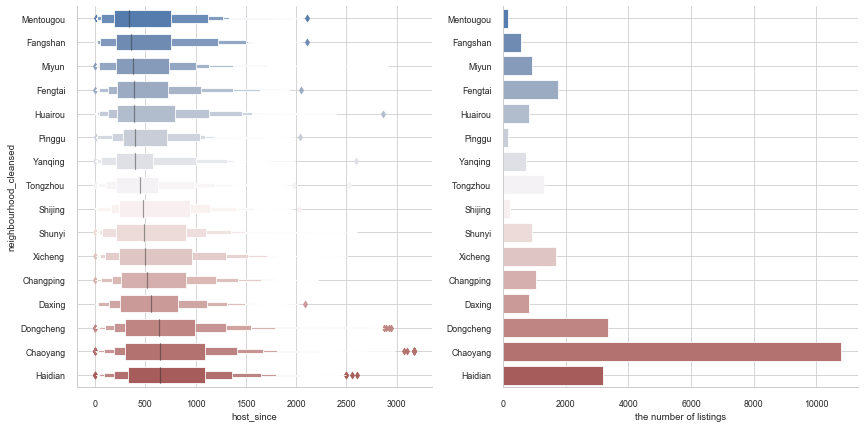

In [46]:
data9 = pd.read_csv('data9.csv')
my_order = data9.groupby(by = ["neighbourhood_cleansed"])["host_since"].median().sort_values().index #按照中位数排序
counts = data9['neighbourhood_cleansed'].value_counts()

sns.set(context = 'paper', style = "whitegrid")
fig = plt.figure(figsize = (14, 7))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.boxenplot(x = 'host_since', y = 'neighbourhood_cleansed', data = data9, palette = "vlag", orient = 'h',
                   linewidth = 0.3, width = 0.7, order = my_order)
ax1.grid(True)

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x = counts.values, y = counts.index,
                  palette = "vlag", orient = 'h', order = my_order)
ax2.set_xlabel('the number of listings')
ax2.grid(True)

sns.despine(trim = False, right = True)

- 海淀区、东城区和朝阳区内的短租房源起步时间较早，并且数量明显高于其他区域。而在较为偏僻的门头沟区、房山区和密云区内，多数房源均为近一两年注册，并且数量较少。造成明显差异的主要原因是，东城区是全市历史文化遗存和胡同四合院最为密集的地区，游客密集并且位于市中心地带，需求拉动了市场发展。而海淀区内旅游景点也较为密集，“集天下胜景于一地，汇古建绝艺于京华”。位于北京中心城区的朝阳区，则是商务中心、科技文化体育交流中心，各地往来人员数量多。

- 短租房源市场发展较晚且数量较少的昌平、通州、顺义、大兴属于北京的近郊，以经济开发区为主，市场需求不高。


<Figure size 1080x504 with 0 Axes>

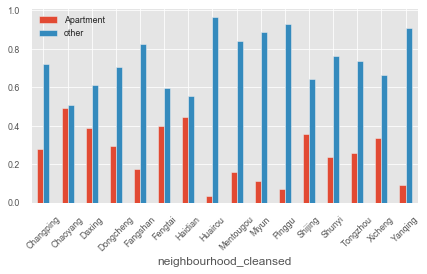

In [48]:
# 讨论为什么朝阳区短租房源数量这么高
data_1 = data9.copy()
data_1.property_type = data_1.property_type.apply(lambda x:'Apartment' if x == 'Apartment' else 'other')
plt.style.use('ggplot')

area_type = pd.crosstab(data_1['neighbourhood_cleansed'], data_1['property_type'])
area_type_std = area_type.div(area_type.sum(1), axis = 0)

plt.figure(figsize = (15,7))
area_type_std.plot.bar()
plt.tight_layout()
plt.xticks(rotation = 45)
plt.legend(loc = 'best')
plt.show()

- 朝阳区的房源数量明显比同为中心城区的其它区域，如西城区、东城区等高出不少。结合房源类型的数量分布，我们已知Apartment（公寓型房源）在北京短租房源市场“一枝独秀”。上图刻画了Apartment类型的房源在各区的占比情况，由此可以发现，朝阳区的公寓型房源占比最高，说明该区域充分利用了居民区的闲置资源，这是它房源数量显著高于其他区域的主要原因。

### 3.2.2 探索房间类型与地理位置的关系

<Figure size 720x504 with 0 Axes>

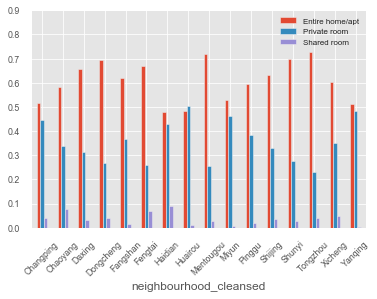

In [49]:
plt.style.use('ggplot')

area_room = pd.crosstab(data_1['neighbourhood_cleansed'], data_1['room_type'])
area_room_std = area_room.div(area_room.sum(1), axis = 0)
fig = plt.figure(figsize = (10, 7))
area_room_std.plot.bar()
plt.xticks(rotation = 45)
plt.ylim(ymin = 0, ymax = 0.9)
plt.legend(loc = 'best', fontsize = 8)
plt.show()

- 房间类型的分布在不同地区间也有明显差异，如上图所示，大兴、东城、房山、丰台、门头沟、石景山、顺义、通州的整套出租房源比较显著较高，而海淀、怀柔、密云、延庆等区整套出租与整间出租的比邻基本“旗鼓相当”。

### 3.2.3 Superhost型房东、价格以及评论数的区域分布情况

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

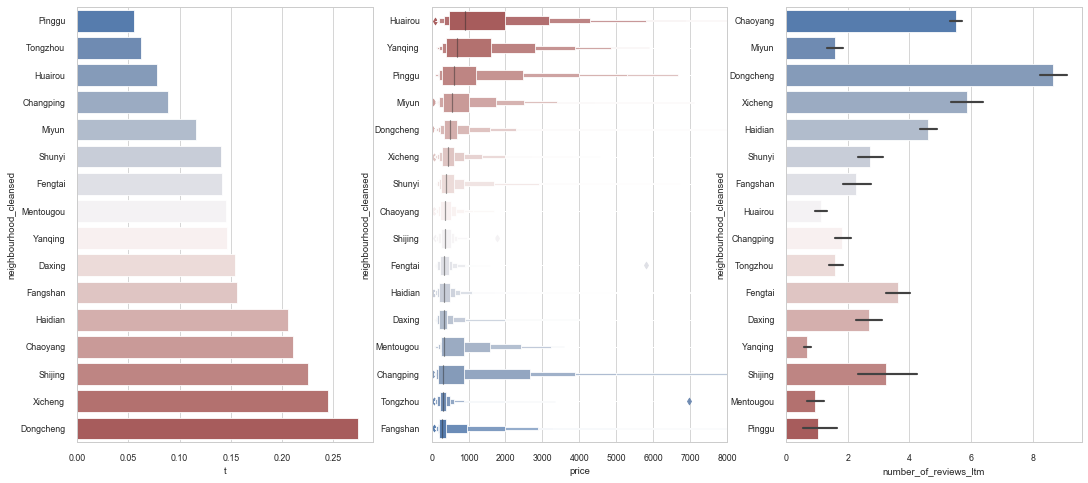

In [50]:
sns.set(context = 'paper', style = "whitegrid")

tab2 = pd.crosstab(data_1['neighbourhood_cleansed'], data_1['host_is_superhost'])
tab2_std = tab2.div(tab2.sum(1), axis = 0)
orders = tab2_std.iloc[:,-1].sort_values().index

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1,3,1)
ax1 = sns.barplot(x = tab2_std.iloc[:,-1], y = tab2_std.index, palette = "vlag", order = orders)

order2 = data_1.groupby(by = ["neighbourhood_cleansed"])["price"].median().sort_values().index #按照中位数排序
ax2 = fig.add_subplot(1,3,2)
ax2 = sns.boxenplot(x = 'price', y = 'neighbourhood_cleansed', data = data_1, palette = "vlag", orient = 'h',
                   linewidth = 0.3, width = 0.7, order = order2)
ax2.axis([0, 8000, -0.5, 15.5])

ax3 = fig.add_subplot(1,3,3)
ax3 = sns.barplot(x = data_1.number_of_reviews_ltm, y = data_1.neighbourhood_cleansed, palette = "vlag")

- 东城区、西城区、石景山区、朝阳区和海淀区的明星房东占比较高，一定程度上体现出这几个区的整体房东素质高于其余各区。
- 从价格分布来看，由于别墅、精品酒店等高价房源数量占比较高，因此怀柔、延庆、平谷等区的价格水平更高。
- 从过去12个月的评论数来看，发展更为成熟的中心城区，如朝阳区、西城区、东城区、海淀区等评论数量更多一些。地理位置相对偏僻，房源数量较少的地区，如怀柔区、延庆区、门头沟区等，住客评论量较少。

## 3.3 房东与房源大体情况分析

### 3.3.1 房东等级与房东注册时长的关系

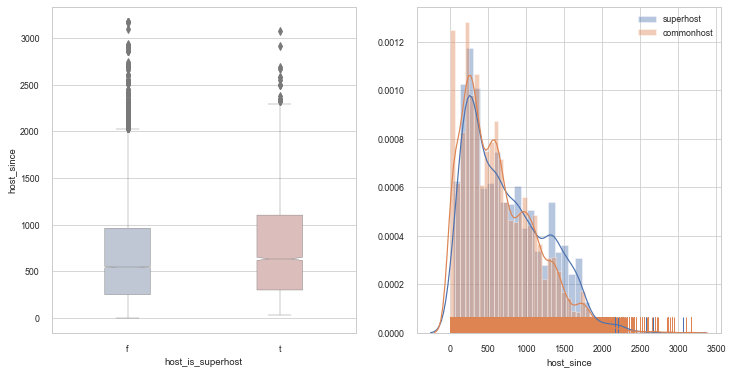

In [51]:
superhost = data_1.query("host_is_superhost == 't'")
commonhost = data_1.query("host_is_superhost == 'f'")

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
sns.boxplot(y = data_1.host_since, x = data_1.host_is_superhost, palette = "vlag", orient = 'v',
                      linewidth = 0.4, width = 0.3, notch = True)

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.distplot(superhost.host_since, rug = True, hist = True, label = 'superhost')
ax2 = sns.distplot(commonhost.host_since, rug = True, hist = True, label = 'commonhost')
ax2.legend(loc = 'best')

- 发现无论是从箱线图中还是从密度图中看，superhost的注册时间都更长，相比commonhost有更多的经营经验

### 3.3.2 房型的发展概况

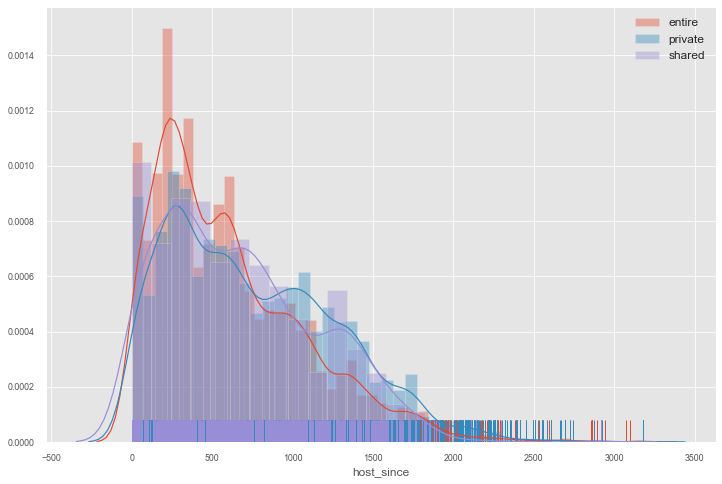

In [59]:
entire = data_1.query("room_type == 'Entire home/apt'")
private = data_1.query("room_type == 'Private room'")
shared = data_1.query("room_type == 'Shared room'")

fig = plt.figure(figsize = (12,8))

ax = fig.add_subplot(1,1,1)
ax = sns.distplot(entire.host_since, rug = True, hist = True, label = 'entire')
ax = sns.distplot(private.host_since, rug = True, hist = True, label = 'private')
ax = sns.distplot(shared.host_since, rug = True, hist = True, label = 'shared')
ax.legend(loc = 'best', fontsize = 12)

- 从整体上来看，entire房间类型注册时间较短，日期较新

### 3.3.3 “明星房东”与房型、注册市场的关系

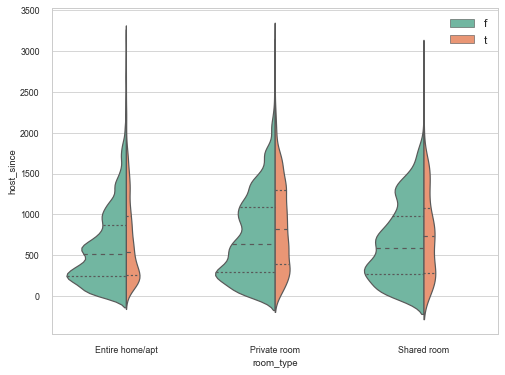

In [63]:
sns.set(context = 'paper', style = "whitegrid")
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(1,1,1)
ax1 = sns.violinplot(x = "room_type", y = "host_since", hue = 'host_is_superhost',
                     data = data_1, palette = "Set2", split = True, scale = "count", inner = "quartile")
ax1.legend(loc = 'best', fontsize = 12)

- 首先，在三种房型中，“明星房东”的注册时长均更久一些
- 其次，Private room的注册时长相较于其他两种房型，较长一些

## 3.4 探究热度高的房源特征
- 以过去12个月的评论数作为评价热度的指标

### 3.4.1 高热度房源地区分布情况

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


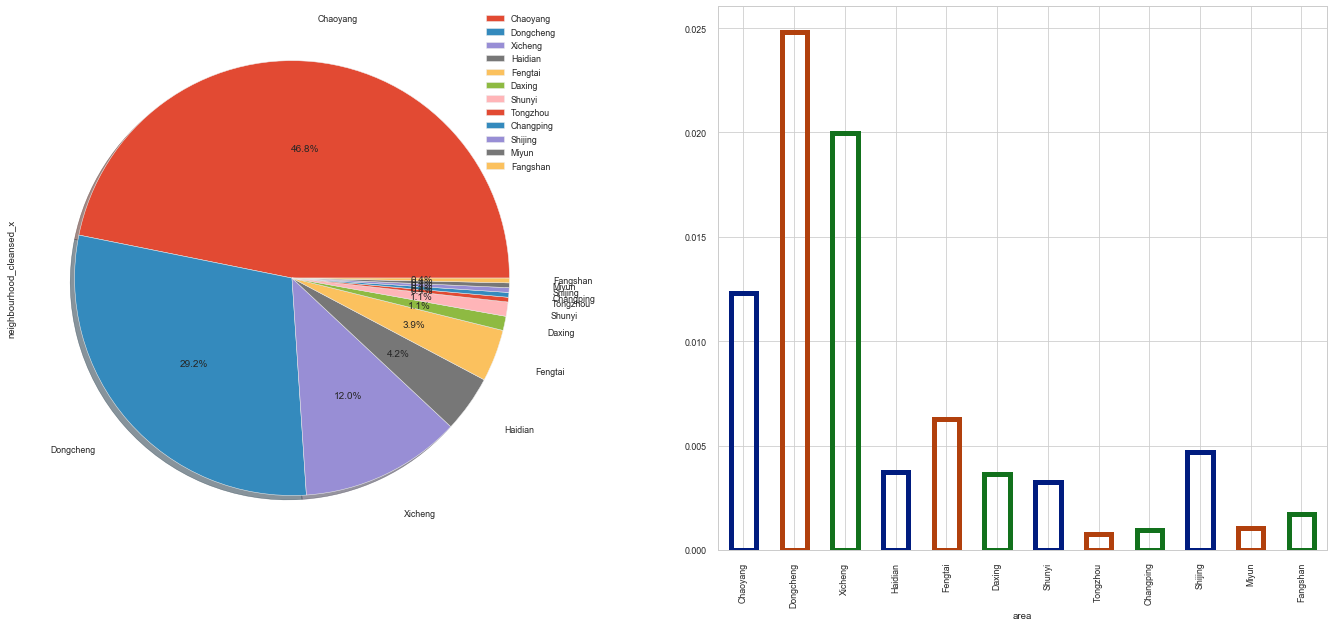

In [67]:
# 取热度前1%的房源
data9 = pd.read_csv('data9.csv')
a = data9.sort_index(by = 'number_of_reviews_ltm', ascending = False)
max10 = a.iloc[:data9.shape[0] // 100,:]

# 查看房源分布
count1 = pd.DataFrame(max10['neighbourhood_cleansed'].value_counts())
count1.index.name = 'area'
count2 = pd.DataFrame(data9.neighbourhood_cleansed.value_counts())
count2.index.name = 'area'

bili = pd.merge(count1, count2, on = 'area')
bili['rate'] = bili.neighbourhood_cleansed_x / bili.neighbourhood_cleansed_y

# 饼图：展示前1%热度房源在各区比例；柱状图：展示各地区中热度前1%房源比例
fig, ax = plt.subplots(1, 2, figsize = (24,10))

plt.style.use('ggplot')
ax[0] = bili.neighbourhood_cleansed_x.plot.pie(ax = ax[0], shadow = True, labeldistance = 1.2,
                                              autopct = "%2.1f%%")
ax[0].legend()

sns.set(context = 'paper', style = "whitegrid")
ax[1] = bili.rate.plot.bar(ax = ax[1],facecolor=(0, 0, 0, 0), linewidth = 5, edgecolor = sns.color_palette("dark", 3))

- 左图为高热度房源的区域分布情况，与各区房源总数基本一致，朝阳区、东城区中高热度房源数量较多，昌平、石景山等区则只有少量的高热度房源。

- 右图为，各区高热度房源所占比例，从图中可以看出，尽管朝阳区高热度房源数量最多，但占比并不具有明显优势，反而是东城区和西城区，尽管数量少，但占比均高于朝阳区。这表明，整体来看，东城区与西城区的房源热度水平更高一些。

### 3.4.2 高热度房源价格跨度

count     284.000000
mean      370.161972
std       252.823145
min        74.000000
25%       201.000000
50%       329.000000
75%       470.000000
max      2221.000000
Name: price, dtype: float64

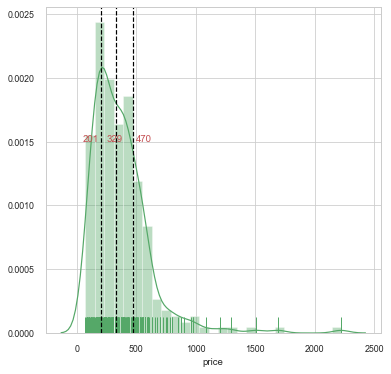

In [68]:
sns.set(context = 'paper', style = "whitegrid")
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(1,1,1)
ax1 = sns.distplot(max10.price, rug = True, hist = True, color = 'g')
plt.axvline(x = 329 ,ls = "--", c = "black")
plt.axvline(x = 201 ,ls = "--", c = "black")
plt.axvline(x = 470 ,ls = "--", c = "black")
plt.text(50,0.0015,'201',color = 'r')
plt.text(250,0.0015,'329',color = 'r')
plt.text(500,0.0015,'470',color = 'r')

max10.price.describe()

- 整体来看，尽管高热度房源价格跨度比较大，最低价格为74，最高为2221，但在价格分布上低于平均水平。侧面说明了，高热度的房源价格更加“亲民”，并且对房东来说，适当降低价格不失为一个提高房源热度的有效措施。

### 3.4.3 高热度房源的房东性质与房间类型分布
- 不止一套的认为是专业的运营团队
- 79.6%都是专业的运营团队

In [71]:
print("专业运用团队比例：", max10[max10.host_listings_count > 1].shape[0] / max10.shape[0])

专业运用团队比例： 0.795774647887324


Entire home/apt    154
Private room       113
Shared room         17
Name: room_type, dtype: int64
Entire home/apt    16955
Private room        9838
Shared room         1659
Name: room_type, dtype: int64


Text(0.5, 1.0, 'All')

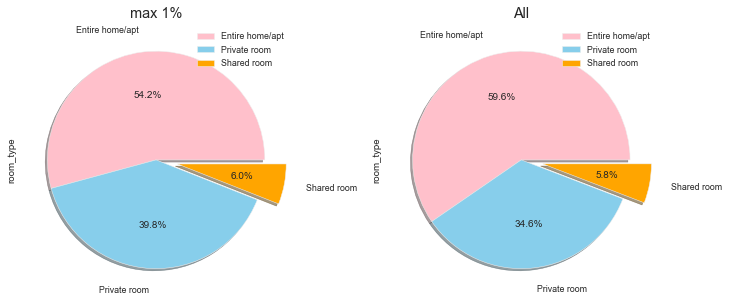

In [72]:
print(max10.room_type.value_counts())
print(data9.room_type.value_counts())

fig, ax = plt.subplots(1,2,figsize=(12,5))
plt.style.use('ggplot')
explode =[0,0,0.2]
colors = ['pink','skyblue','orange']
ax[0] = max10.room_type.value_counts().plot.pie(ax = ax[0], shadow = True, labeldistance = 1.2,
                                                autopct = "%2.1f%%", explode = explode, colors = colors)
ax[0].legend(loc = 'best')
ax[0].set_title('max 1%')

ax[1] = data9.room_type.value_counts().plot.pie(ax = ax[1], shadow = True, labeldistance = 1.2,
                                                autopct = "%2.1f%%", explode = explode, colors = colors)
ax[1].legend(loc = 'best')
ax[1].set_title('All')

- 在高热度房源中，本文认为拥有超过1套房源的房东均为专业的运营团队。根据计算结果，在284个高热度房源中，约79.6%是由专业的运营团队来打理。这表明，可能由于推广和运营相关的环节较弱，个人运营的房源，相对来说入住率会比专业团队差一些。

- 在高热度房源中，单人房间、多人房间比例略高一些，说明这两类房型更受欢迎一些，这也在房源类型方面给房东提供了一定的参考。不过总体而言，类型的分布基本与所有房源的分布相近。